In [1]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
plt.style.use("dark_background")

In [2]:
data = pd.read_csv('C:\\Users\\corey\\Desktop\\git\\portfolio\\data_portfolio\\realestate_ml\\data\\houston_houses_cleaned.csv', index_col=0)
data.head()

,bedrooms,Sqft.,lot Sqft.,full baths,half baths,stories,year built,Private Pool,zip,price
0,3.0,1758.0,7150.0,2.0,0,1.0,1978.0,False,77084,221000.0
1,4.0,2958.0,9400.0,3.0,1,2.0,1980.0,False,77070,359500.0
2,3.0,1120.0,6000.0,2.0,0,1.0,1936.0,False,77008,825000.0
3,3.0,1714.0,5500.0,2.0,0,1.0,1986.0,False,77095,289995.0
5,2.0,1180.0,6960.0,1.0,0,1.0,1955.0,False,77033,128000.0


In [3]:
data.describe()

,bedrooms,Sqft.,lot Sqft.,full baths,half baths,stories,year built,zip,price
count,31019.000000,31019.000000,3.101900e+04,31019.000000,31019.000000,31019.000000,31019.000000,31019.000000,3.101900e+04
mean,3.539186,2343.546923,1.123335e+04,2.383313,0.500435,1.520840,2001.641220,77346.561237,4.696960e+05
std,0.829589,961.899177,4.513430e+04,0.756735,0.535621,0.586735,36.524661,332.664144,4.189112e+05
min,1.000000,125.000000,0.000000e+00,1.000000,0.000000,1.000000,0.000000,71075.000000,1.000000e+00
25%,3.000000,1683.000000,1.701000e+03,2.000000,0.000000,1.000000,1984.000000,77089.000000,2.860000e+05
50%,4.000000,2177.000000,6.391000e+03,2.000000,0.000000,1.000000,2012.000000,77379.000000,3.750000e+05
75%,4.000000,2808.000000,8.760000e+03,3.000000,1.000000,2.000000,2022.000000,77493.000000,5.250000e+05
max,11.000000,15400.000000,1.441410e+06,5.000000,2.000000,5.000000,2022.000000,78950.000000,1.320000e+07


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31019 entries, 0 to 39002
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bedrooms      31019 non-null  float64
 1   Sqft.         31019 non-null  float64
 2   lot Sqft.     31019 non-null  float64
 3   full baths    31019 non-null  float64
 4   half baths    31019 non-null  int64  
 5   stories       31019 non-null  float64
 6   year built    31019 non-null  float64
 7   Private Pool  31019 non-null  bool   
 8   zip           31019 non-null  int64  
 9   price         31019 non-null  float64
dtypes: bool(1), float64(7), int64(2)
memory usage: 2.4 MB


In [5]:
# Convert zip to string to make it a categorical feature

data['zip'] = data['zip'].astype('str')

In [6]:
# Reduce the zip codes into categories from least to most expensive
# Attempts to preserve information about how some areas are more expensive
# while reducing the dimensionality

def reduceZip(df, how='median', bins=5):
    """
    Accepts: dataframe, number of bins and which stat to groupby
    Returns: dataframe with new column categorizing zipcodes by expense
    """
    zipGrouped = df[['zip', 'price']].groupby(['zip']).median() if how == 'median' else df.groupby(['zip']).mean()
    zipGrouped['zipTier'] = pd.cut(zipGrouped['price'], bins=bins, labels=False)
    zipGrouped = zipGrouped.drop(['price'], axis=1)
    return df.merge(zipGrouped, how='left', on='zip')

data = reduceZip(data)
data = data.drop('zip', axis=1)

In [7]:
# Convert year built to "age" of home

data['age'] = data.apply(lambda x: 2022 - x['year built'] + 1 if (x['year built'] and x['year built'] != 0) else 0, axis=1)
data = data.drop(['year built'], axis=1)
anomalous_age = data.loc[data['age'] >= 200]
print(f'Number of rows with "age" greater that 200: {len(anomalous_age)}')
# drop anomolous rows
data = data.loc[data['age'] < 200]


Number of rows with "age" greater that 200: 2


In [8]:
PATH = 'C:\\Users\\corey\\Desktop\\git\\portfolio\\data_portfolio\\realestate_ml\\data\\houston_houses_engineered.csv'
data.to_csv(PATH)

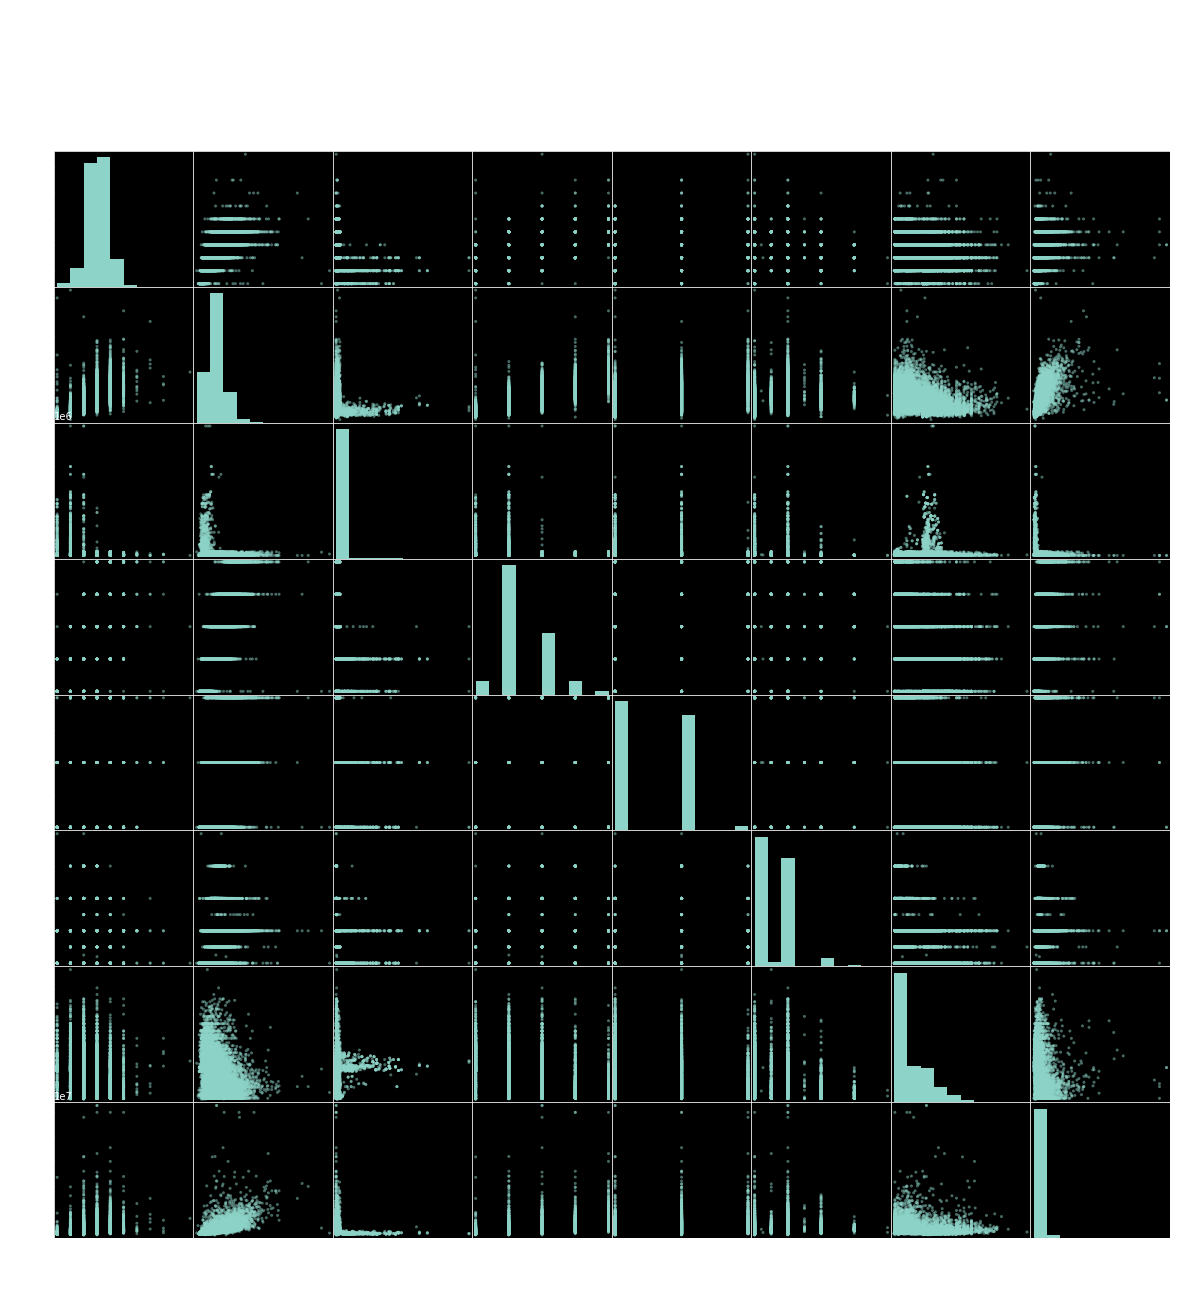

In [9]:
cat_col = ['zip', 'Private Pool', 'zipTier']
num_col = ['bedrooms', 'Sqft.', 'lot Sqft.', 'full baths', 'half baths', 'stories', 'age', 'price']

scatter_matrix(data[num_col], figsize=(20, 20))
plt.suptitle('Scatter Matrix')

plt.show()

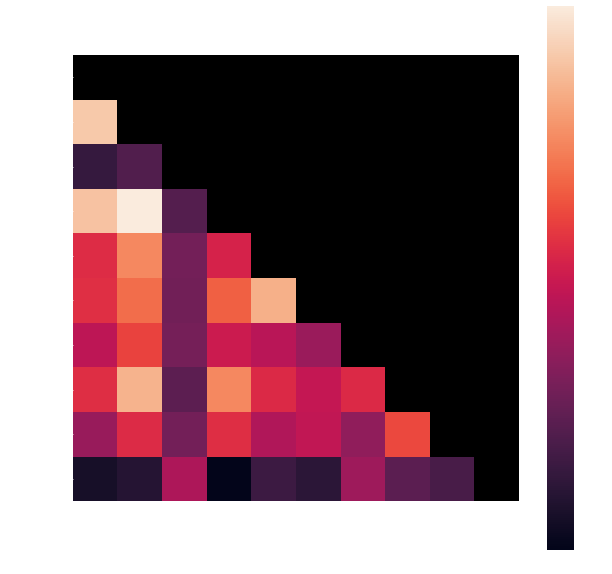

In [10]:
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(corr, 
        mask=mask, 
        yticklabels=corr.columns,
        square=True).set_title('Home data heatmap')
plt.show()

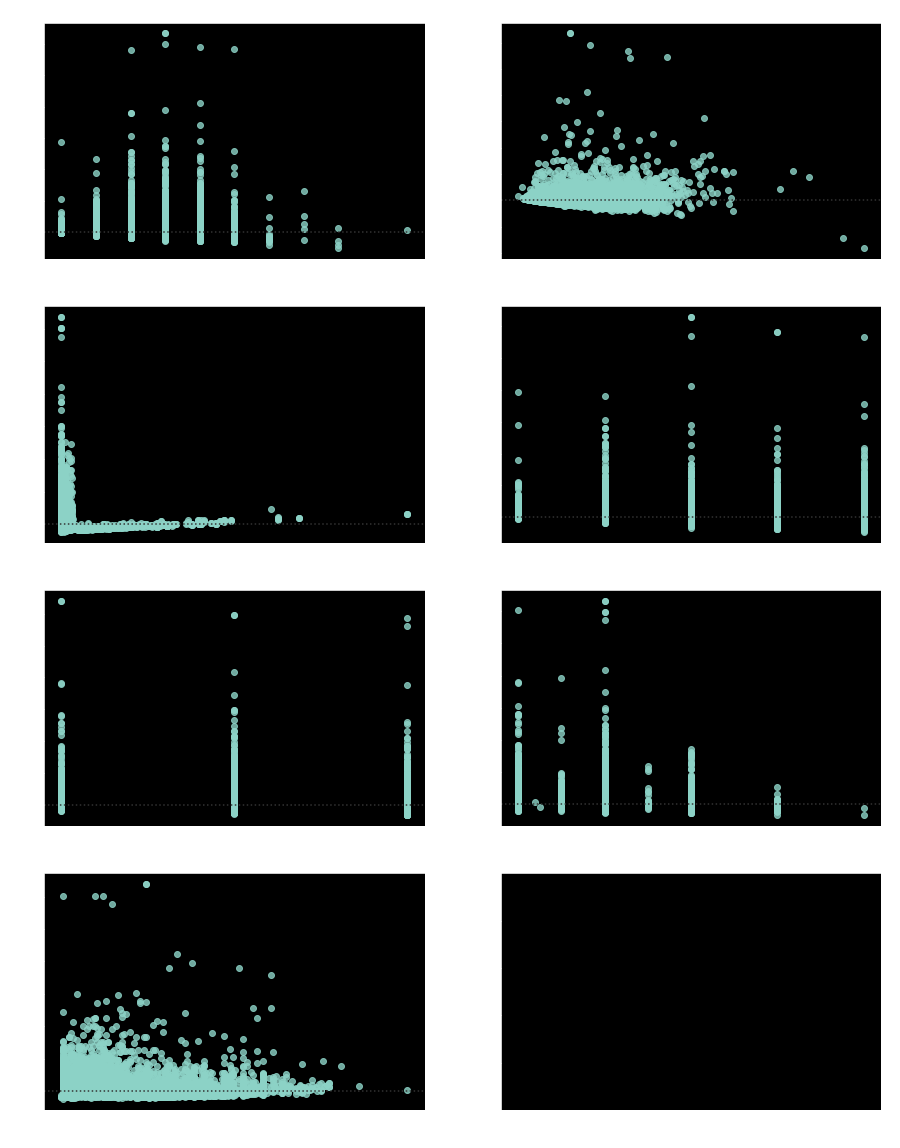

In [11]:
cols = ['bedrooms', 'Sqft.', 'lot Sqft.', 'full baths', 'half baths', 'stories', 'age']
fig, axes = plt.subplots(4, 2, figsize=(15, 20))

for feat, ax in zip(cols, axes.flatten()):
    sns.residplot(data=data, x=feat, y='price', ax=ax).set_title(feat)

In [12]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import Ridge

# parameters = {'alpha':(.1, 1, 10, 100), 
#               'fit_intercept':(True, False),
#               'solver': ('auto', 'lsqr')}

# ridge_reg = Ridge()
# gs = GridSearchCV(ridge_reg, parameters)
# gs.fit(X_train_prep_dropped_first, y_train)

# gs.best_params_


pca, partial corelation, feature importance, partial dependance plot, remove outliers explicitly, bedroom/story to calculate outliers